<a href="https://colab.research.google.com/github/tommyj530/Learning-based-comms-system-using-autoencoder-and-CGAN/blob/main/CGANinTF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoencoder Extensions - Enabling Over-the-Air Transmission with GANs

#### Import libraries

In [ ]:
import glob
import imageio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # Ignore if you do not have multiple GPUs

import time 
from IPython import display

In [ ]:
print(tf.__version__)

2.4.1


#### System parameters

In [ ]:
k = 8       # Number of information bits per message, i.e., M=2**k
n = 8      # Number of real channel uses per message

## Part 1 -  Generative Adversarial networks (GANs)

In this part we define and train a GAN to mimik any unknown channel function.

The GAN is inspired by:
https://wiseodd.github.io/techblog/2016/12/24/conditional-gan-tensorflow/ which also provides further details on GAN training


In [ ]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

In [ ]:
train_SNR_dB = 6 
batch_size = 16
noise_std = EbNo2Sigma(train_SNR_dB) # should be able to vary this based on SNR

#number of neurons per layer in discriminator and generator
G_nb_weights = 32
D_nb_weights = 32

### Generator

In [ ]:
# Concatenate z and y
G_input = tf.keras.Input(shape=(n,), dtype=tf.float32, name='gen_in') 
G_n = tf.random.normal([tf.shape(G_input)[0],n],dtype=tf.float32)
input = tf.concat(values=[G_input, G_n], axis=1)
x = tf.keras.layers.Dense(G_nb_weights,activation="relu")(input)
#x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(G_nb_weights,activation="relu")(x)
x = tf.keras.layers.Dense(n,activation=None)(x)
G_output = x
generator = tf.keras.Model(G_input, G_output, name='generator')
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gen_in (InputLayer)             [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (2,)                 0           gen_in[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici ()                   0           tf.compat.v1.shape[0][0]         
__________________________________________________________________________________________________
tf.random.normal (TFOpLambda)   (None, 8)            0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________

### Discriminator
*  D(y,x)
*   y_fake = generator(x)
*   y_real = real_channel(x)

In our experiment, we use a stochastic channel model to generate y_real, but in practice, we would be taking measurements of the distorted signals and use them as a conditioning paramter for the GAN.

In [ ]:
# Concatenate x and y
D_input_y = tf.keras.Input(shape=(n,), dtype=tf.float32, name='D_in_y')
D_input_x = tf.keras.Input(shape=(n,), dtype=tf.float32, name='D_in_x')
input = tf.concat(values=[D_input_y, D_input_x], axis=1)
x = tf.keras.layers.Dense(D_nb_weights,activation="relu")(input)
#x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(D_nb_weights,activation=None)(x)
x = tf.keras.layers.Dense(1,activation=None)(x)
x = tf.keras.activations.sigmoid(x)
D_output = x
discriminator = tf.keras.Model([D_input_y, D_input_x], D_output, name='discriminator')
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
D_in_y (InputLayer)             [(None, 8)]          0                                            
__________________________________________________________________________________________________
D_in_x (InputLayer)             [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.concat_1 (TFOpLambda)        (None, 16)           0           D_in_y[0][0]                     
                                                                 D_in_x[0][0]                     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           544         tf.concat_1[0][0]    

In [ ]:
x = tf.random.normal((batch_size,n))    #randomly sample input data ("fake" AE messages)
#x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x))) #Average power normalization (not required if standard normal distribution is used )
generated_signal = generator(x, training=False)
decision = discriminator([generated_signal,x])
#print(decision)

In [ ]:
def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random.uniform(tf.shape(x), minval=-2, maxval=2)

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    total_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
    # real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # total_loss = real_loss + fake_loss
    return total_loss

#     D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))   #use "-" sign to minimize rather than maximize loss
#     G_loss = -tf.reduce_mean(tf.log(D_fake))

In [ ]:
def generator_loss(fake_output):
    return  -tf.reduce_mean(tf.math.log(fake_output))

In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

In [ ]:
EPOCHS = 20
noise_dim = n 

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step():
  rv_simple = tf.random.normal([batch_size, noise_dim])
  #rv_simple = x/tf.sqrt(2*tf.reduce_mean(tf.square(rv_simple)))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    y_fake = generator(rv_simple, training=True)
    y_real = real_channel(rv_simple)

    real_output = discriminator([y_real,rv_simple], training=True)
    fake_output = discriminator([y_fake,rv_simple], training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

Test test_step():

In [ ]:
def test_step():
  #parameters
  hist_range = 3
  for i in range(1000):
    hist_range = 3
    rv_simple = tf.random.normal([batch_size, noise_dim])
    if i == 0:
      y_fake = np.array(generator(rv_simple))
      y_fake = y_fake.squeeze().tolist()
      y_real = np.array(real_channel(rv_simple))
      y_real = y_real.squeeze().tolist()
    else:
      temp = np.array(generator(rv_simple))
      temp = temp.squeeze().tolist()
      y_fake = np.append(y_fake,temp)
      temp = np.array(real_channel(rv_simple))
      temp = temp.squeeze().tolist()
      y_real = np.append(y_real,temp)

  #and plot results  
  plt.hist(y_fake,bins=100,range=(-hist_range,hist_range),density=True,histtype='step')   
  plt.hist(y_real,bins=100,range=(-hist_range,hist_range),density=True,histtype='step') 
  plt.title("channel distribution")
  plt.legend(["generator", "target"])
  plt.show()


In [ ]:
checkpoint_dir = 'Desktop/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(epochs):
  gen_loss_prior = 0
  count = 0
  for epoch in range(epochs):
    start = time.time()
    for i in range(1000):
      gen_loss, disc_loss = train_step()
    
    if epoch%2==0:
      test_step()

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print('G Loss is {} and D loss is {}'.format(gen_loss, disc_loss))
    print('-----------------------------------------------------------------')

    if abs(gen_loss-gen_loss_prior)<0.01:
      count = count + 1
    gen_loss_prior = gen_loss

    if count == 3: 
      print ('Early stoppage at epoch {}'.format(epoch))
      break
# Save the model at the end
checkpoint.save('Desktop/checkpoint')
# generator.save_weights('Desktop/checkpt/gen_weights')
# discriminator.save_weights('Desktop/checkpt/dis_weights')

'Desktop/checkpoint-1'

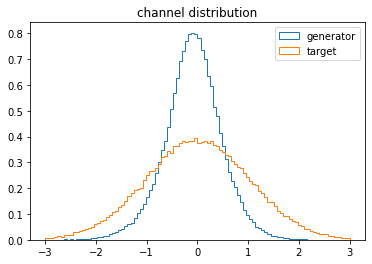

Time for epoch 1 is 4.515899181365967 sec
G Loss is 0.9838271737098694 and D loss is 0.916662335395813
-----------------------------------------------------------------
Time for epoch 2 is 0.6921494007110596 sec
G Loss is 1.145039677619934 and D loss is 1.0270960330963135
-----------------------------------------------------------------


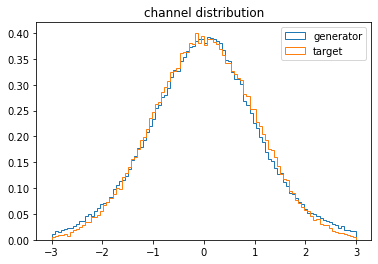

Time for epoch 3 is 3.4276046752929688 sec
G Loss is 1.4244701862335205 and D loss is 0.7909141182899475
-----------------------------------------------------------------
Time for epoch 4 is 0.6865460872650146 sec
G Loss is 1.0611540079116821 and D loss is 1.1703888177871704
-----------------------------------------------------------------


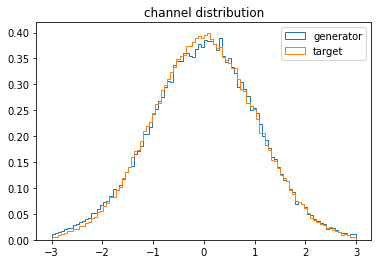

Time for epoch 5 is 3.5391793251037598 sec
G Loss is 1.1295453310012817 and D loss is 1.2004374265670776
-----------------------------------------------------------------
Time for epoch 6 is 0.6790602207183838 sec
G Loss is 1.0427366495132446 and D loss is 1.1561853885650635
-----------------------------------------------------------------


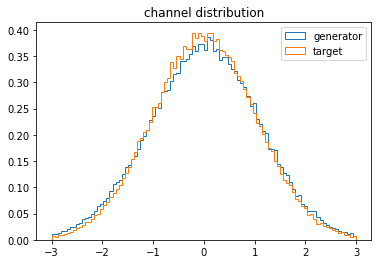

Time for epoch 7 is 3.380979061126709 sec
G Loss is 0.9156176447868347 and D loss is 1.3475316762924194
-----------------------------------------------------------------
Time for epoch 8 is 0.6695132255554199 sec
G Loss is 0.8790110349655151 and D loss is 1.3679378032684326
-----------------------------------------------------------------


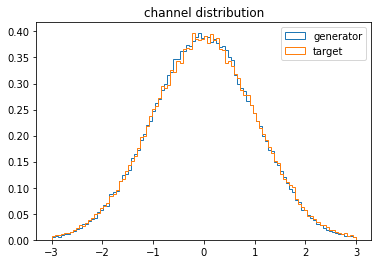

Time for epoch 9 is 3.4386463165283203 sec
G Loss is 0.6816417574882507 and D loss is 1.4182976484298706
-----------------------------------------------------------------
Time for epoch 10 is 0.6651427745819092 sec
G Loss is 0.694427490234375 and D loss is 1.4426263570785522
-----------------------------------------------------------------


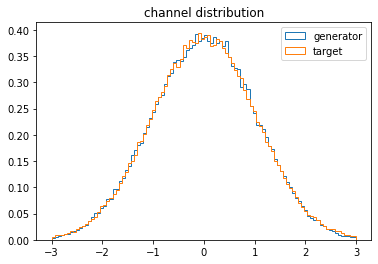

Time for epoch 11 is 3.4021358489990234 sec
G Loss is 0.6608631610870361 and D loss is 1.4853160381317139
-----------------------------------------------------------------
Time for epoch 12 is 0.6772878170013428 sec
G Loss is 0.6648164987564087 and D loss is 1.4528701305389404
-----------------------------------------------------------------


In [ ]:
train(EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))